In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate#Additional scklearn functions
from sklearn import metrics
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
train = pd.read_csv('Data/Train.csv')
target = "labels"
test_file= 'Data/Test.csv'
testdata = pd.read_csv(test_file)
x_test=testdata
sample_data = pd.read_excel("Data/Sample_Submission.xlsx")
# df = dataset
dataset = train

In [3]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

Using TensorFlow backend.


In [174]:
y = dataset.labels
X = dataset.drop('labels', axis=1)
print(Counter(y))
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.3,random_state=20)
# smote = SMOTE(sampling_strategy=0.3,random_state=20)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5,random_state=20)
X, y = under.fit_resample(X, y)
print(Counter(y))

Counter({0: 29941, 1: 3967})
Counter({0: 29941, 1: 8982})
Counter({0: 17964, 1: 8982})


In [554]:
train = X
train["labels"] = y


In [475]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=None)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['labels'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['labels'].values, dtrain_predictions))
    print ("F1 (Train): %f" % metrics.f1_score(dtrain['labels'], dtrain_predictions))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [476]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
# modelfit(xgb1, train, predictors)

In [477]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_

{'mean_fit_time': array([27.76278753, 27.76858544, 33.76507144, 49.20790038, 43.95514688,
        47.5546382 , 61.83494802, 65.61658545, 56.85274453, 72.20974321,
        65.59739356, 67.19861941]),
 'std_fit_time': array([0.17022848, 0.0993536 , 5.28829425, 7.3849638 , 2.85277823,
        1.00358387, 3.08581527, 3.44566456, 0.87458538, 1.75664588,
        2.89762633, 5.44834436]),
 'mean_score_time': array([0.16583643, 0.17032771, 0.23682718, 0.19263749, 0.24713345,
        0.21344795, 0.22235656, 0.20955324, 0.21015301, 0.23936167,
        0.24371986, 0.24499927]),
 'std_score_time': array([0.01672814, 0.02051254, 0.06437181, 0.04094976, 0.04900519,
        0.03979535, 0.05006513, 0.035718  , 0.0247422 , 0.01322338,
        0.03045961, 0.07264197]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             

In [478]:
gsearch1.best_params_

{'max_depth': 5, 'min_child_weight': 3}

In [479]:
gsearch1.best_score_

0.9115187933449175

In [26]:
param_test2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

c:\users\sai krithik\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([20.01274667, 21.45727892, 22.18513966, 26.40045924, 27.87895894,
         26.4756763 , 33.21800694, 31.63257265, 23.43602324]),
  'std_fit_time': array([0.7843828 , 0.8484935 , 0.57094234, 0.93008055, 0.8037403 ,
         1.77199444, 2.44857192, 1.52310948, 5.73643923]),
  'mean_score_time': array([0.08779593, 0.08961277, 0.10440617, 0.11760178, 0.12517395,
         0.10220895, 0.10900345, 0.09700818, 0.09220037]),
  'std_score_time': array([0.01276604, 0.01184018, 0.0259615 , 0.01778339, 0.01504322,
         0.01120789, 0.01374662, 0.01544056, 0.01697896]),
  'param_max_depth': masked_array(data=[6, 6, 6, 7, 7, 7, 8, 8, 8],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 2, 3, 1, 2, 3, 1, 2, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False],


# 'max_depth': 6, 'min_child_weight': 3

In [28]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([16.09281249, 18.36668878, 18.48811021, 18.91349382, 16.12947001]),
  'std_fit_time': array([1.30147064, 0.23565742, 0.19551219, 0.15133721, 5.07170853]),
  'mean_score_time': array([0.11920071, 0.10159135, 0.0844049 , 0.11063771, 0.0723846 ]),
  'std_score_time': array([0.01405133, 0.01446736, 0.01023128, 0.01647368, 0.01656787]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.93256938, 0.93350955, 0.93338335, 0.93271366, 0.93339723]),
  'split1_test_score': array([0.92898833, 0.92853633, 0.92946725, 0.92931897, 0.92936355]),
  'split2_test_score': array([0.92892476, 0.92892476, 0.92967519, 0.93108804, 0.9310933 ]),
  'split3_test_score': array([0.92484359, 0.92460962, 0.9252612 , 0.92526962, 0.925265

# 'gamma': 0.4


Model Report
Accuracy : 0.9401
AUC Score (Train): 0.968675


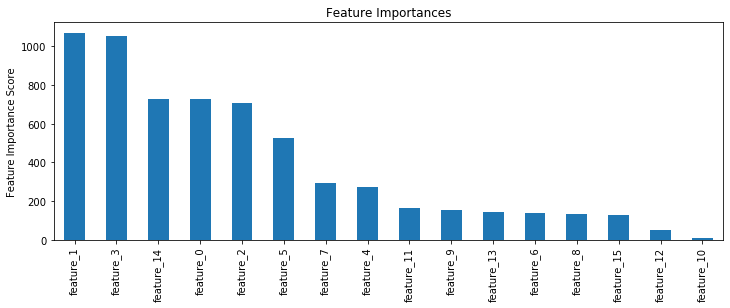

In [29]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=3,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [31]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=3, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

c:\users\sai krithik\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([23.65528874, 27.83542476, 26.20326467, 25.92378235, 29.19382033,
         28.68260212, 27.69261484, 29.10793681, 29.37364721, 28.94004445,
         30.31468263, 33.72884016, 33.49467554, 40.34521995, 37.4595201 ,
         31.46791992]),
  'std_fit_time': array([2.32788734, 0.70085572, 0.38880689, 0.1343918 , 0.33224077,
         0.73890891, 0.39501989, 0.73852834, 0.2065746 , 0.41803536,
         0.92880019, 1.36911363, 3.63181431, 1.78714441, 0.17520705,
         2.46277333]),
  'mean_score_time': array([0.13180256, 0.15499396, 0.12939696, 0.11341305, 0.14495196,
         0.13219962, 0.13340049, 0.1525876 , 0.11128922, 0.12320018,
         0.13757939, 0.15499458, 0.12567358, 0.20640397, 0.15779552,
         0.09840178]),
  'std_score_time': array([0.01613149, 0.05270239, 0.01627953, 0.01472757, 0.04557333,
         0.02721317, 0.02325463, 0.03212674, 0.00570008, 0.02881663,
         0.02239761, 0.04009252, 0.02984667, 0.03424977, 0.07329624,
         0.018229

# 'colsample_bytree': 0.7, 'subsample': 0.9

In [32]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=3, gamma=0, subsample=0.9, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(train[predictors],train[target])

c:\users\sai krithik\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.7, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=6, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=0.9, tree_meth

In [33]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([26.94016786, 26.8497437 , 27.05006104, 27.07431064, 27.20622592,
         28.24262586, 29.49385033, 32.51756415, 27.95134096]),
  'std_fit_time': array([0.27436795, 0.65940937, 0.29802204, 0.1490909 , 0.43890114,
         0.53066843, 0.16675401, 1.60874314, 8.16736206]),
  'mean_score_time': array([0.21279693, 0.1146915 , 0.12687888, 0.10478907, 0.11987996,
         0.11047702, 0.10794234, 0.13819847, 0.10500474]),
  'std_score_time': array([0.09061545, 0.01860706, 0.02256244, 0.01208031, 0.01326112,
         0.00738184, 0.0107335 , 0.03452641, 0.02413082]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, False, False, False, False, Fa

# 'colsample_bytree': 0.75, 'subsample': 0.8

In [34]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=3, gamma=0.4, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

c:\users\sai krithik\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([19.69031363, 22.08470035, 24.36082177, 25.04486103, 15.31651025]),
  'std_fit_time': array([1.18739166, 0.30979979, 1.52587311, 0.52896856, 4.69604075]),
  'mean_score_time': array([0.13903842, 0.17098942, 0.13665137, 0.10336366, 0.07494726]),
  'std_score_time': array([0.03705345, 0.04027041, 0.02361573, 0.01243564, 0.0220627 ]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.93525422, 0.93573776, 0.93557276, 0.93541512, 0.91170965]),
  'split1_test_score': array([0.93376068, 0.93372471, 0.93372871, 0.93380316, 0.90839235]),
  'split2_test_score': array([0.93437696, 0.93496589, 0.93498779, 0.93497958, 0.91059587]),
  'split3_test_score': array([0.93047402, 0.93032303, 0.9306

In [ ]:
# 'reg_alpha': 1

In [ ]:
param_test7 = {
 'reg_alpha':[0, 1, 2, 10]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=3, gamma=0.4, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])

In [38]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([30.33826475, 31.53937602, 33.10899706, 31.20861554]),
  'std_fit_time': array([0.10396187, 1.19851941, 0.64401341, 0.48173874]),
  'mean_score_time': array([0.15081043, 0.12347722, 0.11659036, 0.14078865]),
  'std_score_time': array([0.05228841, 0.01853821, 0.01823241, 0.04816216]),
  'param_reg_alpha': masked_array(data=[0, 1, 2, 10],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 1},
   {'reg_alpha': 2},
   {'reg_alpha': 10}],
  'split0_test_score': array([0.9358505 , 0.93542122, 0.93672315, 0.93511772]),
  'split1_test_score': array([0.93244655, 0.93378171, 0.93430858, 0.93381284]),
  'split2_test_score': array([0.93453783, 0.9361288 , 0.93486303, 0.93358168]),
  'split3_test_score': array([0.93045317, 0.93055563, 0.93144001, 0.93011454]),
  'split4_test_score': array([0.93440475, 0.93492534, 0.93458312, 0.93415551]),
  'mean_test_score': array([0.933538

# 'reg_alpha': 2

In [ ]:
xgb3 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=2000,
 max_depth=7,
 min_child_weight=2,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.75,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [ ]:
xgb3.fit(X,y)

In [ ]:
scores1 = cross_val_score(xgb3, X, y, cv=3, scoring='f1')

In [176]:
scores1.mean

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [177]:
# del X["labels"]
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
boosting = AdaBoostClassifier(base_estimator=xgb3, n_estimators=3)   
boosting.fit(X, y)


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=XGBClassifier(base_score=0.5, booster=None,
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.75,
                                                gamma=0.4, gpu_id=-1,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=0.01,
                                                max_delta_step=0, max_depth=7,
                                                min_child_weight=2, missing=nan,
                                                monotone_constraints=None,
                                                n_estimators=2000, n_jobs=4,
                                                nthread=4, num_parallel_tr

In [ ]:
 scores2 = cross_val_score(boosting, X, y, cv=3, scoring='f1')

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [182]:
y_Pred = xgb3.predict(x_test)
# y_Pred = boosting.predict(x_test)

In [183]:
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
0,0.947747,-0.259225,-0.217055,-0.105477,-0.569351,-0.411453,-0.251940,9,1,3,0,1,1,2,8,3
1,-0.841558,0.196972,-0.337213,-0.497672,-0.569351,-0.411453,-0.251940,4,2,2,0,0,0,0,4,3
2,-0.559037,-0.445777,0.383734,0.038198,0.076230,-0.411453,-0.251940,1,2,1,0,0,0,2,8,3
3,-0.559037,-0.101248,0.624050,-0.590867,-0.569351,-0.411453,-0.251940,10,1,1,1,1,1,0,9,3
4,-0.370689,0.329004,0.263576,1.568147,0.399020,-0.411453,-0.251940,4,1,2,0,0,0,1,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26941,-0.653211,-0.367609,0.263576,0.966263,-0.569351,-0.411453,-0.251940,1,1,1,0,1,0,0,8,3
26942,0.194355,-0.256926,-0.577529,4.876564,-0.569351,2.434914,0.616335,4,0,2,0,1,0,0,8,0
26943,-1.218254,-0.410306,-0.337213,-0.210322,0.076230,0.647196,0.182198,9,2,1,0,0,0,0,1,0
26944,-0.747384,-0.347903,-1.538792,0.376029,-0.569351,2.604697,1.918749,9,1,1,0,1,0,0,3,2


In [184]:
Output = pd.DataFrame(columns = ["labels"])

In [185]:
Output["labels"]=y_Pred
Output["labels"].value_counts()
# y_Pred

0    9446
1    1857
Name: labels, dtype: int64

In [164]:
Output

,labels
0,1
1,0
2,0
3,0
4,0
...,...
11298,0
11299,0
11300,1
11301,0


In [165]:
Output.to_excel('CallofdutyBrawlStars2.xlsx', index = False)